In [2]:
import pandas as pd
import seaborn as sn
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler,OrdinalEncoder, OneHotEncoder
from sklearn.compose import ColumnTransformer
from lazypredict.Supervised import LazyRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.neighbors import KNeighborsRegressor

In [3]:
data = pd.read_csv("StudentScore20523.xls")
print(data.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 8 columns):
 #   Column                       Non-Null Count  Dtype 
---  ------                       --------------  ----- 
 0   gender                       1000 non-null   object
 1   race/ethnicity               1000 non-null   object
 2   parental level of education  1000 non-null   object
 3   lunch                        1000 non-null   object
 4   test preparation course      1000 non-null   object
 5   math score                   1000 non-null   int64 
 6   reading score                1000 non-null   int64 
 7   writing score                1000 non-null   int64 
dtypes: int64(3), object(5)
memory usage: 62.6+ KB
None


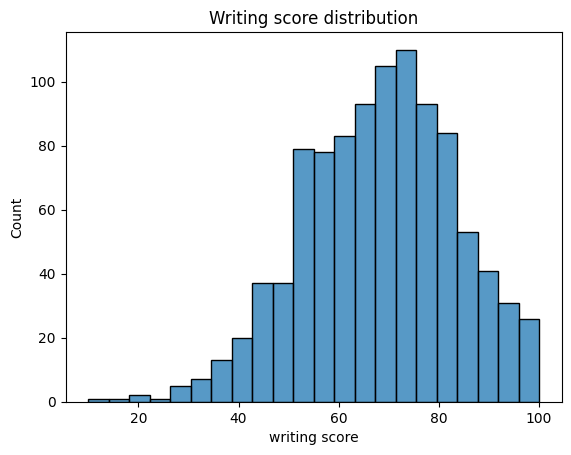

In [6]:
data = pd.read_csv("StudentScore20523.xls")
target = "writing score"
sn.histplot(data["writing score"])
plt.title("Writing score distribution")
plt.savefig("WritingDistribution.png")

In [7]:
# Chia dữ liệu theo chiều dọc
x = data.drop(target, axis = 1)
y = data[target]
# Chia dữ liệu theo chiều dọc
x = data.drop(target, axis = 1)
y = data[target]
# Chia dữ liệu theo chiều ngang
x_train, x_test, y_train, y_test = train_test_split(x, y, train_size=0.8, random_state=42)

In [7]:
print(x["gender"].unique())
print(x["race/ethnicity"].unique())
print(x["parental level of education"].unique())
print(x["lunch"].unique())
print(x["test preparation course"].unique())


['female' 'male']
['group B' 'group C' 'group A' 'group D' 'group E']
["bachelor's degree" 'some college' "master's degree" "associate's degree"
 'high school' 'some high school']
['standard' 'free/reduced']
['none' 'completed']


In [10]:

#Tích hợp bước kiểm tra dữ liệu bị khuyết + tiền xử lí
num_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler())
])

education_values = ["some high school", "high school", "some college", "associate's degree", "bachelor's degree",
                    "master's degree"]
gender_values = ["male", "female"]
lunch_values = x_train["lunch"].unique()
test_values = x_train["test preparation course"].unique()
ord_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="constant", fill_value="unknown")),
    ("encoder", OrdinalEncoder(categories=[education_values, gender_values, lunch_values, test_values]))
])

nom_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="constant", fill_value="unknown")),
    ("encoder", OneHotEncoder(sparse=False))
])



In [11]:
education_values = ["some high school", "high school", "some college", "associate's degree", "bachelor's degree",
                    "master's degree"]
gender_values = ["male", "female"]
lunch_values = x_train["lunch"].unique()
test_values = x_train["test preparation course"].unique()
ord_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="constant", fill_value="unknown")),
    ("encoder", OrdinalEncoder(categories=[education_values, gender_values, lunch_values, test_values]))
])



In [15]:
nom_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="constant", fill_value="unknown")),
    ("encoder", OneHotEncoder(sparse=False))
])
result3 = nom_transformer.fit_transform(x_train[["race/ethnicity"]])



In [11]:
preprocessor = ColumnTransformer(transformers=[
    ("num_features", num_transformer, ["reading score", "writing score"]),
    ("ordinal_features", ord_transformer, ["parental level of education", "gender", "lunch", "test preparation course"]),
    ("nominal_features", nom_transformer, ["race/ethnicity"]),
])

In [12]:
reg = Pipeline(steps=[
    ("preprocessor",preprocessor),
    ("regressor",RandomForestRegressor())
])
parameters = {
    "regressor__n_estimators": [50, 100, 200, 500],
    "regressor__criterion": ["squared_error", "absolute_error", "poisson"],
    "regressor__max_depth": [None, 5, 10, 20],
    "regressor__max_features": ["sqrt", "log2"],
    "preprocessor__num_features__imputer__strategy": ["mean", "median"],
}
reg.fit(x_train,y_train)
y_predict = reg.predict(x_test)
print("MAE {}".format(mean_absolute_error(y_test,y_predict)))
print("MSE {}".format((mean_squared_error(y_test,y_predict))))
print("R2 {}".format((r2_score(y_test,y_predict))))

# model = GridSearchCV(reg, param_grid=parameters, scoring="r2", cv=6, verbose=2, n_jobs=8)
model = RandomizedSearchCV(reg, param_distributions=parameters, scoring="r2", cv=6, verbose=1, n_iter=20, n_jobs=8)
model.fit(x_train, y_train)
print(model.best_score_)
print(model.best_params_)

MAE 4.537026785714286
MSE 35.167383414328235
R2 0.8554795157101048
Fitting 6 folds for each of 20 candidates, totalling 120 fits
0.8287644976793315
{'regressor__n_estimators': 500, 'regressor__max_features': 'sqrt', 'regressor__max_depth': 10, 'regressor__criterion': 'squared_error', 'preprocessor__num_features__imputer__strategy': 'mean'}


In [17]:
reg1 = Pipeline(steps=[
    ("preprocessor", preprocessor),
    ("regressor", SVR()),   ##Linear Regression ; SVR ; KNeighborsRegressor
])
parameters = {
     "regressor__kernel": ["linear","poly","rbf","sigmoid"],
     "regressor__degree": [3,4],
     "regressor__gamma": ["scale","auto"],
     "preprocessor__num_features__imputer__strategy": ["mean", "median"],
}
reg1.fit(x_train,y_train)
y_predict1 = reg1.predict(x_test)
print("MAE {}".format(mean_absolute_error(y_test,y_predict1)))
print("MSE {}".format((mean_squared_error(y_test,y_predict1))))
print("R2 {}".format((r2_score(y_test,y_predict1))))
model2 = RandomizedSearchCV(reg1, param_distributions=parameters, scoring="r2", cv=6, verbose=1, n_iter=20, n_jobs=8)
model2.fit(x_train, y_train)
print(model2.best_score_)
print(model2.best_params_)


MAE 5.601828693469095
MSE 63.028441403745
R2 0.7409844011313258
Fitting 6 folds for each of 20 candidates, totalling 120 fits
0.8623705422518152
{'regressor__kernel': 'linear', 'regressor__gamma': 'scale', 'regressor__degree': 4, 'preprocessor__num_features__imputer__strategy': 'mean'}


In [18]:
reg2 = Pipeline(steps=[
    ("preprocessor", preprocessor),
    ("regressor", LinearRegression()),   ##Linear Regression ; SVR ; KNeighborsRegressor
])
reg2.fit(x_train,y_train)
y_predict2 = reg2.predict(x_test)
print("MAE {}".format(mean_absolute_error(y_test,y_predict2)))
print("MSE {}".format((mean_squared_error(y_test,y_predict2))))
print("R2 {}".format((r2_score(y_test,y_predict2))))


MAE 4.181966418321512
MSE 28.821056563832887
R2 0.8815597679452446


In [19]:
reg3 = Pipeline(steps=[
    ("preprocessor", preprocessor),
    ("regressor", KNeighborsRegressor()),   ##Linear Regression ; SVR ; KNeighborsRegressor
])
parameters = {
     "regressor__n_neighbors": [5,6],
     "regressor__algorithm": ["auto","ball_tree","kd_tree","brute"],
     "regressor__leaf_size": [30,60],
     "preprocessor__num_features__imputer__strategy": ["mean", "median"],
 }
reg3.fit(x_train,y_train)
y_predict3 = reg3.predict(x_test)
print("MAE {}".format(mean_absolute_error(y_test,y_predict3)))
print("MSE {}".format((mean_squared_error(y_test,y_predict3))))
print("R2 {}".format((r2_score(y_test,y_predict3))))
model3 = RandomizedSearchCV(reg3, param_distributions=parameters, scoring="r2", cv=6, verbose=1, n_iter=20, n_jobs=8)
model3.fit(x_train, y_train)
print(model3.best_score_)
print(model3.best_params_)

MAE 5.797000000000001
MSE 55.3242
R2 0.7726450079395607
Fitting 6 folds for each of 20 candidates, totalling 120 fits
0.7652736115072596
{'regressor__n_neighbors': 5, 'regressor__leaf_size': 30, 'regressor__algorithm': 'brute', 'preprocessor__num_features__imputer__strategy': 'median'}
